# Lecture 12 - applications of eigenvalue problems

This notebook presents two applications of eigenvalue problems. The examples were covered in the lectures, and are presented in more depth here. The two examples are 

1. The PageRank algorithm for racking the importance of web pages
1. Vibration of a multi degree-of-freedom mass-spring system


## PageRank

PageRank is a algorithm used by Google to rank the 'importance' of a web page. The concept is that every web page has an importance score, and it 'endows' its importance evenly amongst the pages to which it links. The will lead to a problem where the ranking of all pages is an eigenvalue problem. We will demonstrate the process for the small web of four pages.

This is a larger version of the the example from the lectures.

### Model problem

Consider a web of five pages, $p_{0}$, $p_{1}$, $p_{2}$, $p_{3}$ and $p_{4}$. Consider the scenario:

- $p_{0}$ links to: $p_{1}$, $p_{2}$, $p_{3}$ and $p_{4}$
- $p_{1}$ links to: $p_{2}$, $p_{3}$ and $p_{4}$
- $p_{2}$ links to: $p_{0}$ and $p_{1}$
- $p_{3}$ links to: $p_{0}$ and $p_{2}$
- $p_{4}$ links to: $p_{1}$ and $p_{2}$ and $p_{3}$

We can build a directed graph to describe the connections, and for this we use the package `networkx` (https://networkx.github.io/). To visualise the graph we use Matplotlib.

In [1]:
import sys
if 'conda' in sys.version:  # Install using conda if we're using Anaconda Python
    !conda install -y -c omnia pygraphviz=1.3.1


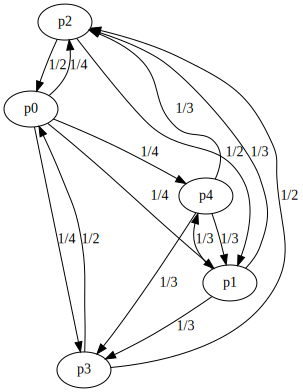

In [2]:
import networkx as nx

# Create a directed networkx graph
G = nx.DiGraph()

# Add web pages (graph nodes)
#for i in range(5):
#   G.add_node(i, labelss="p" + str(i))

# Add outgoing web links (directed graph edges)
G.add_edge("p0", "p1", label="0.2")
G.add_edge("p0", "p2")
G.add_edge("p0", "p3")
G.add_edge("p0", "p4")

G.add_edge("p1", "p2")
G.add_edge("p1", "p3")
G.add_edge("p1", "p4")

G.add_edge("p2", "p0")
G.add_edge("p2", "p1")

G.add_edge("p3", "p0")
G.add_edge("p3", "p2")

G.add_edge("p4", "p1")
G.add_edge("p4", "p2")
G.add_edge("p4", "p3")

# Add weights to graph edges
for node in G.nodes_iter():
    # Get number of outgoing edges
    num_edges = len(G.edges(node))

    # For each outgoing edge, weight = 1/num_edges    
    for edge in G.edges(node):
        G[edge[0]][edge[1]]['weight'] = 1/num_edges
        G[edge[0]][edge[1]]['label'] = "{}/{}".format(1, num_edges)

# To plot graph, convert to a PyGraphviz graph for drawing
Ag = nx.nx_agraph.to_agraph(G)
Ag.layout(prog='dot')
Ag.draw('web.svg')
from IPython.display import SVG
SVG('web.svg')

Note that edges have been given a weight which is $1/n$, where $n$ is the number of outgoing link/edges from a page/node. The is the fraction of page's importance/rank that it can give to the pages to which it links. 

If we denote the rank/importance of page $i$ by $x_{i}$, we can express the importance of each page:

$$
\begin{align}
x_{0} =& \tfrac{1}{2} x_{2} + \tfrac{1}{2} x_{3}
\\
x_{1} =& \tfrac{1}{4}x_{0} + \tfrac{1}{2}x_{2} + \tfrac{1}{3}x_{4} 
\\
x_{2} =& \tfrac{1}{4}x_{0} + \tfrac{1}{3}x_{1} + \tfrac{1}{2}x_{3} + \tfrac{1}{3}x_{4}
\\
x_{3} =& \tfrac{1}{4}x_{0} + \tfrac{1}{3}x_{1} + \tfrac{1}{3}x_{4}
\\
x_{4} =& \tfrac{1}{4}x_{0} + \tfrac{1}{3}x_{1}
\end{align}
$$

We can express this as a system of equation:

$$
\underbrace{
\begin{bmatrix}
0 & 0 & \tfrac{1}{2} & \tfrac{1}{2} & 0
\\
\tfrac{1}{4} & 0 & \tfrac{1}{2} & 0 & \tfrac{1}{3}
\\
\tfrac{1}{4} & \tfrac{1}{3} & 0 & \tfrac{1}{2} & \tfrac{1}{3}
\\
\tfrac{1}{4} & \tfrac{1}{3} & 0 & 0 & \tfrac{1}{3}
\\
\tfrac{1}{4} & \tfrac{1}{3} & 0 & 0 & 0
\end{bmatrix}}_{\boldsymbol{A}}
\begin{bmatrix}
x_{0} \\ x_{1} \\ x_{2} \\ x_{3} \\ x_{4}
\end{bmatrix}
=
\begin{bmatrix}
x_{0} \\ x_{1} \\ x_{2} \\ x_{3} \\ x_{4}
\end{bmatrix}
$$

This is an eigenvalue problem with eigenvalue $\lambda = 1$. To solve the problem we need to find the corresponding eigenvector.

First, we can create the matrix $\boldsymbol{A}$ directly from the graph (note that we added weights to the graph edges when building the graph):

In [3]:
# Get the matrix containing the graph weights. We provide node nodelist 
# so that the rows/columns are in the right order 
A = (nx.adjacency_matrix(G, nodelist=sorted(G.nodes())).T).toarray()
print(A)

[[ 0.          0.          0.5         0.5         0.        ]
 [ 0.25        0.          0.5         0.          0.33333333]
 [ 0.25        0.33333333  0.          0.5         0.33333333]
 [ 0.25        0.33333333  0.          0.          0.33333333]
 [ 0.25        0.33333333  0.          0.          0.        ]]


Note that the columns of $\boldsymbol{A}$ sum to one. Such a matrix is known as a *stochastic matrix*. In our context, what is important is that the largest eigenvalue (in absolute terms) for such a matrix is one. Therefore, we are looking for the eigenvector associated with the largest eigenvalue.

### Direct computation of the PageRank vector

To find the solution, we can compute the eigenvectors of $\boldsymbol{A}$, and pick the eigenvectors that corresponds to $\lambda = 1$:

In [4]:
# Compute the eigenvalues and eigenvectors
import numpy as np
np.set_printoptions(precision=6)
evalues, evectors = np.linalg.eig(A)

# Print largest eigenvalue and corresponding eigenvector
np.set_printoptions(precision=6)
print("The maxiumum eigenvalue is: {}".format(np.max(evalues)))
evector = evectors[:, np.argmax(evalues)]
evector /= np.linalg.norm(evector, 1)
print("The PageRank vector (eigenvector) is: \n {}".format(evector))

The maxiumum eigenvalue is: (0.9999999999999991+0j)
The PageRank vector (eigenvector) is: 
 [ 0.215054+0.j  0.225806+0.j  0.258065+0.j  0.172043+0.j  0.129032+0.j]


The PageRank vector has been normalised using the $l_{1}$ norm such the the entries sum to one.

### Approximation of the PageRank vector via matrix multiplication

The direct computation of all eigenvalues and eigenvectors is an expensive operation, and can only be reasonably performed for small matrices. However, we are interested only in the eigenvector corresponding to the largest eigenvalue. Recall that, in almost all cases, the repeated multiplication of a vector by a matrix $\boldsymbol{A}$ will yield a vector that tends to the direction of the eigenvector corresponding to the largest eigenvalue. We can use this to approximate the PageRank vector using only matrix-vector multiplication:

In [5]:
# Create random starting vector
x0 = np.random.rand(A.shape[0])

# Perform 5 iterations
for i in range(5):
    x0 = A.dot(x0)
x0 = x0/np.linalg.norm(x0 ,1)
print("Estimated PageRank after 5 iterations: {}".format(x0))

# Perform another 5 iterations
for i in range(5):
    x0 = A.dot(x0)
x0 = x0/np.linalg.norm(x0 ,1)
print("Estimated PageRank after 10 iterations: {}".format(x0))


Estimated PageRank after 5 iterations: [ 0.216057  0.225977  0.258317  0.171573  0.128076]
Estimated PageRank after 10 iterations: [ 0.215051  0.225801  0.258073  0.172047  0.129027]


It is clear that the approximate solution is very close to the exact solution with relatively few iterations. The major advantage of this method is that it is computationally inexpensive, which makes it tractable for very large matrices.

## Multiple degree of freedom mass-spring system

Eigenvalues and eigenvectors are used to understand the dynamic response of mass-spring systems.


### System of equations

The equations of motion for a multi degree-of-freedom mass-spring system are:

$$
\boldsymbol{M} \ddot{\boldsymbol{x}} + \boldsymbol{K} \boldsymbol{x}  = \boldsymbol{0}
$$

where $\boldsymbol{x}$ are the displacements of the masses.  For the problem in the lecture with two masses (of equal mass) connected by springs of equal stiffness, the 'mass matrix' $\boldsymbol{M}$ is 

$$
\boldsymbol{M} = 
\begin{bmatrix}
m_{1} & 0\\ 0 & m_{2} 
\end{bmatrix}
$$

and the 'stiffness matrix' $\boldsymbol{K}$ is 

$$
\boldsymbol{K} = 
\begin{bmatrix}
k_{1} + k_{2} & -k_{2} \\ -k_{2} & k_{2} 
\end{bmatrix}
$$

### Eigenvectors and eigenvalues

We now take a brief excursion into the properties of eiegenvectors related to the matrices $\boldsymbol{K}$ and $\boldsymbol{M}$. The purpose will soon be clear.

Consider the eigenpairs for the 'generalised' eigenvalue problem

$$
\boldsymbol{K} \boldsymbol{u}_{i} =  \lambda_{i} \boldsymbol{M} \boldsymbol{u}_{i} 
$$

where $\lambda_{i}$ is an eigenvalue and $\boldsymbol{u}_{i}$ is an eigenvector. 

### Orthogonality of the eigenvectors

Multiplying both sides of the above equation by $\boldsymbol{u}_{j}^{T}$:

$$
\boldsymbol{u}_{j}^{T} \boldsymbol{K} \boldsymbol{u}_{i} =  \lambda_{i} \boldsymbol{u}_{j}^{T} \boldsymbol{u}_{i},
$$

Since the eigenvectors are orthogonal with respect to $\boldsymbol{K}$ and $\boldsymbol{M}$ (see lecture notes), and if they are normalised such that $\boldsymbol{u}^{T}_{i} \boldsymbol{M} \boldsymbol{u}_{i} = 1$, it follows that

$$
\boldsymbol{u}_{j}^{T} \boldsymbol{M} \boldsymbol{u}_{i} = 
\begin{cases}
1  & \text{if} \ i = j,
\\
0 & \text{if} \ i \ne j.
\end{cases}
$$

From $\boldsymbol{K} \boldsymbol{u}_{i} =  \lambda_{i} \boldsymbol{M} \boldsymbol{u}_{i}$ and the above orthogonality property,
it then also follows that

$$
\boldsymbol{u}_{j}^{T} \boldsymbol{K} \boldsymbol{u}_{i}
\begin{cases}
\lambda_{i}  & \text{if} \ i = j,
\\
0 & \text{if} \ i \ne j.
\end{cases}
$$

### Decoupling the modes

Since the eigenvectors are linearly independent, we can use them as a basis to express the displacement vector $\boldsymbol{x}$

$$
\boldsymbol{x} = \sum_{i} \alpha_{i} \boldsymbol{u}_{i} = \alpha_{1} \boldsymbol{u}_{1} + \alpha_{2} \boldsymbol{u}_{2},
$$

where $\alpha_{i}$ are unknowns. Taking two derivatives with respect to time:

$$
\ddot{\boldsymbol{x}} = \sum_{i} \ddot{\alpha}_{i} \boldsymbol{u}_{i} = \ddot{\alpha}_{1} \boldsymbol{u}_{1} + \ddot{\alpha}_{2} \boldsymbol{u}_{2}
$$

Inserting these expressions into $\boldsymbol{M} \ddot{\boldsymbol{x}} + \boldsymbol{K} \boldsymbol{x}  = \boldsymbol{0}$,

$$
\boldsymbol{M} \sum_{i} \ddot{\alpha}_{i} \boldsymbol{u}_{i}  + \boldsymbol{K} \sum_{i} \alpha_{i} \boldsymbol{u}_{i} = \boldsymbol{0}
$$

Multiplying both sides of the above equation by $\boldsymbol{u}^{T}_{j}$ 

$$
\boldsymbol{u}^{T}_{j} \boldsymbol{M} \sum_{i} \ddot{\alpha}_{i} \boldsymbol{u}_{i}  + \boldsymbol{u}^{T}_{j} \boldsymbol{K} \sum_{i} \alpha_{i} \boldsymbol{u}_{i} = \boldsymbol{0}
$$

From the orthogonality properties of the eigenvectors, for the case $i \ne j$ the above becomes the trivial '$0 =0$', and when $i = j$ we get the ordinary differential equation

$$
 \ddot{\alpha}_{i} + \lambda_{i} \alpha_{i} = 0
$$

for every $i$. This is a second-order, constant coefficient equation which is easy to solve:

$$
 \alpha_{i} = A_{i}\sin(\sqrt{\lambda_{i}}t) + B_{i}\cos(\sqrt{\lambda_{i}}t)
$$

Hence the displacement vector is 

$$
\boldsymbol{x} = \sum_{i} (A_{i}\sin(\sqrt{\lambda_{i}}t) + B_{i}\cos(\sqrt{\lambda_{i}}t)) \boldsymbol{u}_{i}
$$

where $\sqrt{\lambda_{i}}$ is the $i$th natural frequency, and $\boldsymbol{u}_{i}$ is known as 
the $i$th vibration mode. The constants $A_{i}$ and $B_{i}$ are determined from the initial conditions.

### Solution for the $2 \times 2$ system

To get the complete solution describing the motion of the masses we need to compute the eigenvalues and eigenvectors of of $\boldsymbol{K} \boldsymbol{x} = \lambda \boldsymbol{M} \boldsymbol{x}$. We first create the matrices $\boldsymbol{K}$ and $\boldsymbol{M}$: 

In [6]:
import numpy as np
k1, k2 = 1.0, 1.0
K = np.array([[k1 + k2, -k2], [-k2, k2]] )
print(K)

[[ 2. -1.]
 [-1.  1.]]


In [7]:
m1, m2 = 1.0, 1.0
M = np.array([[m1, 0], [0, m2]] )
print(M)

[[ 1.  0.]
 [ 0.  1.]]


We now compute the eigenvalues and eigenvectors of the generalised problem:

In [8]:
from scipy.linalg import eigh # Use eigh, which is specialised for symmetric matrices

evalues, evectors = eigh(K, M)
print(evalues)
print(evectors)

[ 0.381966  2.618034]
[[-0.525731 -0.850651]
 [-0.850651  0.525731]]


The motion of the masses is therefore

$$
\boldsymbol{x} = 
(A_{1}\sin(\sqrt{0.381966} t) + B_{1}\cos(\sqrt{0.381966} t)) \begin{bmatrix}-0.525731 \\  -0.850651\end{bmatrix}
+
(A_{2}\sin(\sqrt{2.618034} t) + B_{2}\cos(\sqrt{2.618034} t)) \begin{bmatrix} -0.850651 \\  0.525731\end{bmatrix}
$$

#### Exercise

Give the two springs different stiffness and examine the influence on the natural frequencies.

### Motion for given initial conditions

If at $t = 0$ the conditions are $\boldsymbol{x} = \begin{bmatrix} 1 & 1 \end{bmatrix}^{T}$ and $\dot{\boldsymbol{x}} = \begin{bmatrix} 0 & 0 \end{bmatrix}^{T}$, we have 

$$
\begin{bmatrix}
-0.525731 & -0.850651 
\\
-0.850651 & 0.525731 
\end{bmatrix}
\begin{bmatrix}
B_{1} \\ B_{2}
\end{bmatrix}
=
\begin{bmatrix}
1 \\ 1
\end{bmatrix}
$$

We can compute $B_{1}$ and $B_{2}$ using NumPy:

In [9]:
B = np.linalg.inv(evectors).dot(np.array([1, 1]))
print(B)

[-1.376382 -0.32492 ]


### Animating the motion of the masses

For this case, we can use Matplotlib to crate an animation of the motion of the masses. We evaluate the solution to the ODE for each mass for a range of time steps.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 6), ylim=(-2, 2))
ax.grid()
line, = ax.plot([], [], 'o-', markersize=10, lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def x(t):
    alpha0 = B[0]*np.cos(np.sqrt(evalues[0])*t)
    alpha1 = B[1]*np.cos(np.sqrt(evalues[1])*t)
    return evectors[:,0]*alpha0[:,np.newaxis] + evectors[:,1]*alpha1[:,np.newaxis] 

t = np.linspace(0, 8*np.pi, 100, retstep=True)
dt = t[1]
disp = x(t[0]) 

def animate(i):
    zero = [0, 0, 0]
    x0 = [0, disp[i, 0] + 2.0, disp[i, 1] + 4.0]
    x1 = [0, 0, 0]
    
    line.set_data(x0, zero)
    time_text.set_text(time_template%(i*dt))
    return line, time_text

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

anim = animation.FuncAnimation(fig, animate, np.arange(0, len(disp)),
                                interval=100, blit=False, init_func=init)
    
# Call animation function to display the animation
plt.close(anim._fig)
HTML(anim.to_html5_video())

KeyError: 'ffmpeg'

#### Exercise

Try changing the spring stiffnesses $k_{1}$ and $k_{2}$, and the masses $m_{1}$ and $m_{2}$ to investigate what effect these have on the vibration response.